# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

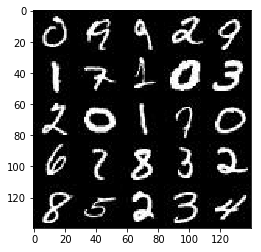

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

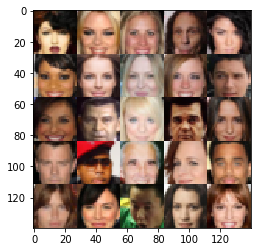

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01, training=False, keep_prob=0.7):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized convolutional layer 
    def conv2d_batch_normalized(input_, depth, kernel_size, stride_size, activation):
        conv = tf.layers.conv2d(input_, depth, kernel_size, strides=stride_size, padding='same', use_bias=False,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=training)
        conv = activation(conv)
        if training:
            conv = tf.nn.dropout(conv, keep_prob)
        return conv
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Apply some convolutions
        conv1 = conv2d_batch_normalized(images, 256, 5, 2, lrelu) 
        conv2 = conv2d_batch_normalized(conv1, 512, 5, 2, lrelu)
        conv3 = conv2d_batch_normalized(conv2, 1024, 5, 2, lrelu)
        
        shape = conv3.get_shape().as_list()
        
        # Reshape, get logits and sigmoid
        flattened = tf.reshape(conv3, [-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized transpose convolution
    def conv2d_trans_batch_normalized(input_, depth, kernel_size, stride_size, activation, padding='same'):
        conv = tf.layers.conv2d_transpose(input_, depth, kernel_size, strides=stride_size, padding=padding, use_bias=False,
                                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = activation(conv)
        if is_train:
            conv = tf.nn.dropout(conv, keep_prob)
        return conv
    
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        # Get a deep layer from the random input
        x = tf.layers.dense(z, 1024*3*3, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x = tf.reshape(x, [-1, 3, 3, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x)
        if is_train:
            x = tf.nn.dropout(x, keep_prob=0.7)
        
        # Apply some transpose convolutions
        conv1 = conv2d_trans_batch_normalized(x, 512, 5, 2, lrelu) # 6x6x512
        conv2 = conv2d_trans_batch_normalized(conv1, 256, 4, 2, lrelu, 'valid') # 14x14x256
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 2, padding='same', # 28x28x(out_channel_dim)
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02)) 
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01, smooth=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    disc_fake_out, disc_fake_logits = discriminator(gen_out, reuse=True, alpha=alpha)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_real_logits)*(1-smooth),
        logits = disc_real_logits
    ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.zeros_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return disc_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode,alpha=0.01):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         alpha = 0.01, print_every=50, show_every=500, gen_samples=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, channels = data_shape
    input_real, z_input, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, z_input, channels, alpha=alpha)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_n = 0           
            for batch_images in get_batches(batch_size):
                # Normalize images to be in the [-1, 1] range
                batch_images *= 2
                
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))            
                sess.run(disc_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                # Seen in slack: run generator twice to avoid the discriminator overpowering it
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                if batch_n % print_every == 0:
                    dloss = disc_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    gloss = gen_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    print("Epoch: {}, Batch: {}, Disc. Loss: {:4f}, Gen. Loss: {:4f}".format(epoch_i+1, batch_n, dloss, gloss))
                
                if batch_n % show_every == 0:
                    show_generator_output(sess, gen_samples, z_input, channels, data_image_mode, alpha=alpha)
                    
                batch_n += 1
            show_generator_output(sess, gen_samples, z_input, channels, data_image_mode, alpha=alpha)
    
    return sess 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1, Batch: 0, Disc. Loss: 1.554843, Gen. Loss: 0.257342


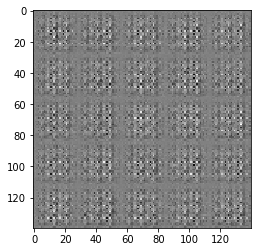

Epoch: 1, Batch: 50, Disc. Loss: 1.059545, Gen. Loss: 0.891972
Epoch: 1, Batch: 100, Disc. Loss: 1.028088, Gen. Loss: 0.893332
Epoch: 1, Batch: 150, Disc. Loss: 0.936478, Gen. Loss: 0.942844
Epoch: 1, Batch: 200, Disc. Loss: 0.816714, Gen. Loss: 1.041783
Epoch: 1, Batch: 250, Disc. Loss: 1.216336, Gen. Loss: 0.690800
Epoch: 1, Batch: 300, Disc. Loss: 0.817520, Gen. Loss: 1.299414
Epoch: 1, Batch: 350, Disc. Loss: 1.192480, Gen. Loss: 0.887196
Epoch: 1, Batch: 400, Disc. Loss: 1.055756, Gen. Loss: 0.751440
Epoch: 1, Batch: 450, Disc. Loss: 1.138150, Gen. Loss: 1.295875
Epoch: 1, Batch: 500, Disc. Loss: 1.208196, Gen. Loss: 0.989301


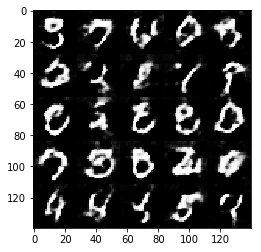

Epoch: 1, Batch: 550, Disc. Loss: 1.304361, Gen. Loss: 0.535632
Epoch: 1, Batch: 600, Disc. Loss: 1.042419, Gen. Loss: 0.938907
Epoch: 1, Batch: 650, Disc. Loss: 1.076209, Gen. Loss: 0.755680
Epoch: 1, Batch: 700, Disc. Loss: 1.261377, Gen. Loss: 0.521231
Epoch: 1, Batch: 750, Disc. Loss: 1.466877, Gen. Loss: 0.612710
Epoch: 1, Batch: 800, Disc. Loss: 1.227133, Gen. Loss: 0.907810
Epoch: 1, Batch: 850, Disc. Loss: 1.186927, Gen. Loss: 0.901751
Epoch: 1, Batch: 900, Disc. Loss: 1.086131, Gen. Loss: 0.873264
Epoch: 1, Batch: 950, Disc. Loss: 1.180986, Gen. Loss: 0.631839
Epoch: 1, Batch: 1000, Disc. Loss: 1.127491, Gen. Loss: 0.709035


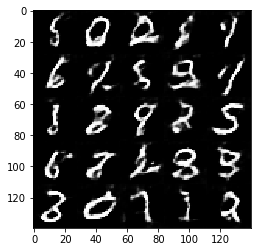

Epoch: 1, Batch: 1050, Disc. Loss: 1.145714, Gen. Loss: 0.961511
Epoch: 1, Batch: 1100, Disc. Loss: 1.159160, Gen. Loss: 1.208392
Epoch: 1, Batch: 1150, Disc. Loss: 1.223726, Gen. Loss: 0.792919
Epoch: 1, Batch: 1200, Disc. Loss: 1.202194, Gen. Loss: 0.741889
Epoch: 1, Batch: 1250, Disc. Loss: 1.065618, Gen. Loss: 1.062797
Epoch: 1, Batch: 1300, Disc. Loss: 1.218158, Gen. Loss: 0.777696
Epoch: 1, Batch: 1350, Disc. Loss: 1.211302, Gen. Loss: 0.869768
Epoch: 1, Batch: 1400, Disc. Loss: 1.038661, Gen. Loss: 0.900070
Epoch: 1, Batch: 1450, Disc. Loss: 0.980610, Gen. Loss: 0.962433
Epoch: 1, Batch: 1500, Disc. Loss: 0.833863, Gen. Loss: 1.257802


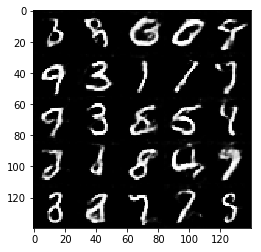

Epoch: 1, Batch: 1550, Disc. Loss: 1.288125, Gen. Loss: 1.310805
Epoch: 1, Batch: 1600, Disc. Loss: 0.944716, Gen. Loss: 1.160009
Epoch: 1, Batch: 1650, Disc. Loss: 1.132025, Gen. Loss: 1.062021
Epoch: 1, Batch: 1700, Disc. Loss: 0.886995, Gen. Loss: 1.243960
Epoch: 1, Batch: 1750, Disc. Loss: 1.217319, Gen. Loss: 0.615587
Epoch: 1, Batch: 1800, Disc. Loss: 0.944191, Gen. Loss: 1.542168
Epoch: 1, Batch: 1850, Disc. Loss: 1.114155, Gen. Loss: 1.229192


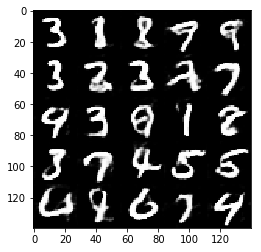

Epoch: 2, Batch: 0, Disc. Loss: 1.140505, Gen. Loss: 0.694877


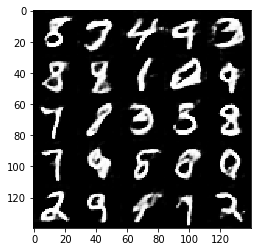

Epoch: 2, Batch: 50, Disc. Loss: 0.934306, Gen. Loss: 0.863491
Epoch: 2, Batch: 100, Disc. Loss: 1.052151, Gen. Loss: 1.216766
Epoch: 2, Batch: 150, Disc. Loss: 1.220863, Gen. Loss: 0.714623
Epoch: 2, Batch: 200, Disc. Loss: 1.034054, Gen. Loss: 1.027455
Epoch: 2, Batch: 250, Disc. Loss: 0.840139, Gen. Loss: 1.165746
Epoch: 2, Batch: 300, Disc. Loss: 0.810162, Gen. Loss: 0.891308
Epoch: 2, Batch: 350, Disc. Loss: 0.909561, Gen. Loss: 1.220745
Epoch: 2, Batch: 400, Disc. Loss: 1.024355, Gen. Loss: 1.200588
Epoch: 2, Batch: 450, Disc. Loss: 1.063102, Gen. Loss: 1.074826
Epoch: 2, Batch: 500, Disc. Loss: 1.022230, Gen. Loss: 1.106634


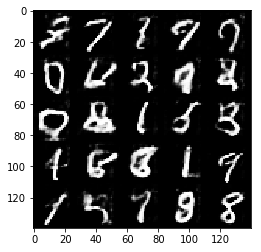

Epoch: 2, Batch: 550, Disc. Loss: 1.133036, Gen. Loss: 0.671274
Epoch: 2, Batch: 600, Disc. Loss: 1.008416, Gen. Loss: 1.051464
Epoch: 2, Batch: 650, Disc. Loss: 0.806733, Gen. Loss: 1.224378
Epoch: 2, Batch: 700, Disc. Loss: 0.880902, Gen. Loss: 1.073698
Epoch: 2, Batch: 750, Disc. Loss: 0.829395, Gen. Loss: 1.506381
Epoch: 2, Batch: 800, Disc. Loss: 0.747788, Gen. Loss: 1.255803
Epoch: 2, Batch: 850, Disc. Loss: 0.954649, Gen. Loss: 0.888934
Epoch: 2, Batch: 900, Disc. Loss: 0.792662, Gen. Loss: 1.593285
Epoch: 2, Batch: 950, Disc. Loss: 0.777845, Gen. Loss: 1.214906
Epoch: 2, Batch: 1000, Disc. Loss: 1.075538, Gen. Loss: 1.727394


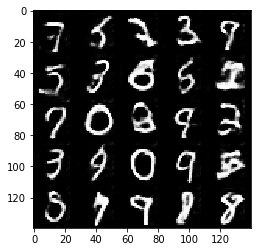

Epoch: 2, Batch: 1050, Disc. Loss: 0.850588, Gen. Loss: 1.499684
Epoch: 2, Batch: 1100, Disc. Loss: 0.806128, Gen. Loss: 1.361013
Epoch: 2, Batch: 1150, Disc. Loss: 0.947673, Gen. Loss: 0.999100
Epoch: 2, Batch: 1200, Disc. Loss: 0.788893, Gen. Loss: 1.461209
Epoch: 2, Batch: 1250, Disc. Loss: 0.906655, Gen. Loss: 0.795724
Epoch: 2, Batch: 1300, Disc. Loss: 1.028638, Gen. Loss: 0.759377
Epoch: 2, Batch: 1350, Disc. Loss: 0.766188, Gen. Loss: 1.331113
Epoch: 2, Batch: 1400, Disc. Loss: 0.902267, Gen. Loss: 0.987611
Epoch: 2, Batch: 1450, Disc. Loss: 0.721712, Gen. Loss: 1.695610
Epoch: 2, Batch: 1500, Disc. Loss: 0.734660, Gen. Loss: 1.642751


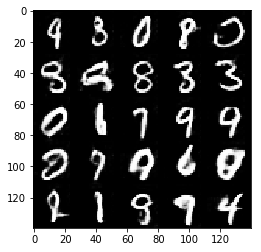

Epoch: 2, Batch: 1550, Disc. Loss: 0.785996, Gen. Loss: 1.339500
Epoch: 2, Batch: 1600, Disc. Loss: 0.616151, Gen. Loss: 1.498908
Epoch: 2, Batch: 1650, Disc. Loss: 0.829848, Gen. Loss: 1.440552
Epoch: 2, Batch: 1700, Disc. Loss: 0.867173, Gen. Loss: 0.946982
Epoch: 2, Batch: 1750, Disc. Loss: 1.026190, Gen. Loss: 0.790567
Epoch: 2, Batch: 1800, Disc. Loss: 0.973419, Gen. Loss: 0.902193
Epoch: 2, Batch: 1850, Disc. Loss: 0.805090, Gen. Loss: 1.141518


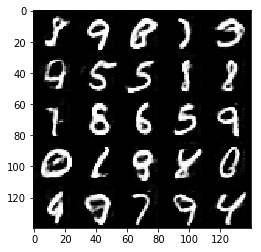

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    mnist_sess = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, 
                       mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1, Batch: 0, Disc. Loss: 1.844578, Gen. Loss: 0.192905


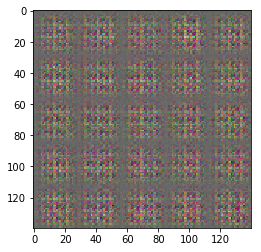

Epoch: 1, Batch: 50, Disc. Loss: 1.220685, Gen. Loss: 2.708677
Epoch: 1, Batch: 100, Disc. Loss: 0.993631, Gen. Loss: 0.807300
Epoch: 1, Batch: 150, Disc. Loss: 1.216639, Gen. Loss: 2.559183
Epoch: 1, Batch: 200, Disc. Loss: 0.770692, Gen. Loss: 1.174145
Epoch: 1, Batch: 250, Disc. Loss: 0.892066, Gen. Loss: 1.566725
Epoch: 1, Batch: 300, Disc. Loss: 0.992283, Gen. Loss: 1.147543
Epoch: 1, Batch: 350, Disc. Loss: 1.251934, Gen. Loss: 0.686584
Epoch: 1, Batch: 400, Disc. Loss: 1.106008, Gen. Loss: 0.834244
Epoch: 1, Batch: 450, Disc. Loss: 1.150692, Gen. Loss: 0.724387
Epoch: 1, Batch: 500, Disc. Loss: 1.195724, Gen. Loss: 1.074817


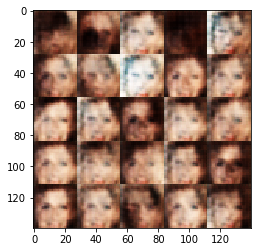

Epoch: 1, Batch: 550, Disc. Loss: 1.172443, Gen. Loss: 0.787503
Epoch: 1, Batch: 600, Disc. Loss: 1.293905, Gen. Loss: 0.680939
Epoch: 1, Batch: 650, Disc. Loss: 1.000454, Gen. Loss: 0.867737
Epoch: 1, Batch: 700, Disc. Loss: 1.210186, Gen. Loss: 0.818401
Epoch: 1, Batch: 750, Disc. Loss: 1.425510, Gen. Loss: 0.836177
Epoch: 1, Batch: 800, Disc. Loss: 1.423048, Gen. Loss: 0.799605
Epoch: 1, Batch: 850, Disc. Loss: 1.091355, Gen. Loss: 0.954830
Epoch: 1, Batch: 900, Disc. Loss: 1.334868, Gen. Loss: 0.776359
Epoch: 1, Batch: 950, Disc. Loss: 1.318641, Gen. Loss: 0.693741
Epoch: 1, Batch: 1000, Disc. Loss: 1.408140, Gen. Loss: 0.615626


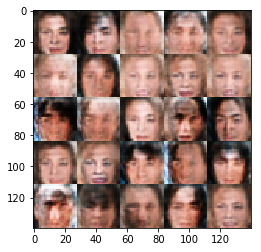

Epoch: 1, Batch: 1050, Disc. Loss: 1.212579, Gen. Loss: 0.816103
Epoch: 1, Batch: 1100, Disc. Loss: 1.341922, Gen. Loss: 0.684553
Epoch: 1, Batch: 1150, Disc. Loss: 1.416374, Gen. Loss: 0.677735
Epoch: 1, Batch: 1200, Disc. Loss: 1.316681, Gen. Loss: 0.818311
Epoch: 1, Batch: 1250, Disc. Loss: 1.448318, Gen. Loss: 0.515932
Epoch: 1, Batch: 1300, Disc. Loss: 1.271730, Gen. Loss: 0.894567
Epoch: 1, Batch: 1350, Disc. Loss: 1.272092, Gen. Loss: 0.579179
Epoch: 1, Batch: 1400, Disc. Loss: 1.310097, Gen. Loss: 0.752954
Epoch: 1, Batch: 1450, Disc. Loss: 1.282480, Gen. Loss: 0.808065
Epoch: 1, Batch: 1500, Disc. Loss: 1.105029, Gen. Loss: 0.763848


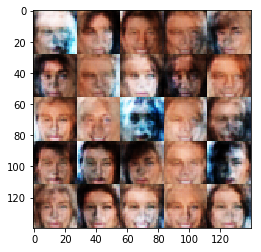

Epoch: 1, Batch: 1550, Disc. Loss: 1.383382, Gen. Loss: 0.786350
Epoch: 1, Batch: 1600, Disc. Loss: 1.263931, Gen. Loss: 0.889251
Epoch: 1, Batch: 1650, Disc. Loss: 1.136936, Gen. Loss: 0.704342
Epoch: 1, Batch: 1700, Disc. Loss: 1.327929, Gen. Loss: 0.735716
Epoch: 1, Batch: 1750, Disc. Loss: 1.350741, Gen. Loss: 0.765237
Epoch: 1, Batch: 1800, Disc. Loss: 1.374912, Gen. Loss: 0.711326
Epoch: 1, Batch: 1850, Disc. Loss: 1.779530, Gen. Loss: 0.485757
Epoch: 1, Batch: 1900, Disc. Loss: 1.280738, Gen. Loss: 0.955485
Epoch: 1, Batch: 1950, Disc. Loss: 1.260659, Gen. Loss: 0.758406
Epoch: 1, Batch: 2000, Disc. Loss: 1.216289, Gen. Loss: 0.716461


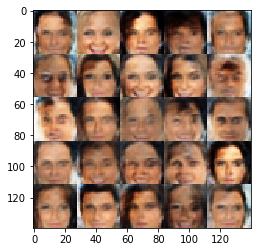

Epoch: 1, Batch: 2050, Disc. Loss: 1.292226, Gen. Loss: 0.743739
Epoch: 1, Batch: 2100, Disc. Loss: 1.299146, Gen. Loss: 0.806432
Epoch: 1, Batch: 2150, Disc. Loss: 1.282664, Gen. Loss: 0.704194
Epoch: 1, Batch: 2200, Disc. Loss: 1.184391, Gen. Loss: 0.824000
Epoch: 1, Batch: 2250, Disc. Loss: 1.310009, Gen. Loss: 1.014047
Epoch: 1, Batch: 2300, Disc. Loss: 1.215888, Gen. Loss: 0.766009
Epoch: 1, Batch: 2350, Disc. Loss: 1.356370, Gen. Loss: 0.853795
Epoch: 1, Batch: 2400, Disc. Loss: 1.297083, Gen. Loss: 0.661126
Epoch: 1, Batch: 2450, Disc. Loss: 1.411855, Gen. Loss: 0.758626
Epoch: 1, Batch: 2500, Disc. Loss: 1.764335, Gen. Loss: 0.429465


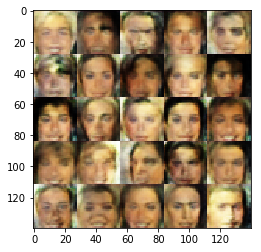

Epoch: 1, Batch: 2550, Disc. Loss: 1.294091, Gen. Loss: 0.717958
Epoch: 1, Batch: 2600, Disc. Loss: 1.328447, Gen. Loss: 0.702510
Epoch: 1, Batch: 2650, Disc. Loss: 1.257997, Gen. Loss: 0.796307
Epoch: 1, Batch: 2700, Disc. Loss: 1.250705, Gen. Loss: 0.917295
Epoch: 1, Batch: 2750, Disc. Loss: 1.344540, Gen. Loss: 0.812262
Epoch: 1, Batch: 2800, Disc. Loss: 1.304829, Gen. Loss: 0.694941
Epoch: 1, Batch: 2850, Disc. Loss: 1.179692, Gen. Loss: 0.743492
Epoch: 1, Batch: 2900, Disc. Loss: 1.127962, Gen. Loss: 0.817965
Epoch: 1, Batch: 2950, Disc. Loss: 1.257034, Gen. Loss: 0.794367
Epoch: 1, Batch: 3000, Disc. Loss: 1.198568, Gen. Loss: 0.867898


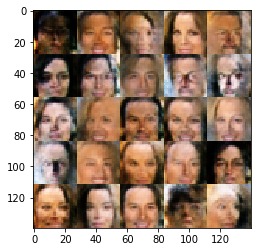

Epoch: 1, Batch: 3050, Disc. Loss: 1.206535, Gen. Loss: 0.856906
Epoch: 1, Batch: 3100, Disc. Loss: 1.302495, Gen. Loss: 0.904629
Epoch: 1, Batch: 3150, Disc. Loss: 1.242302, Gen. Loss: 0.749024
Epoch: 1, Batch: 3200, Disc. Loss: 1.336306, Gen. Loss: 0.770584
Epoch: 1, Batch: 3250, Disc. Loss: 1.228615, Gen. Loss: 0.759767
Epoch: 1, Batch: 3300, Disc. Loss: 1.330119, Gen. Loss: 0.842616
Epoch: 1, Batch: 3350, Disc. Loss: 1.223070, Gen. Loss: 0.698407
Epoch: 1, Batch: 3400, Disc. Loss: 1.214622, Gen. Loss: 0.902469
Epoch: 1, Batch: 3450, Disc. Loss: 1.261631, Gen. Loss: 0.850075
Epoch: 1, Batch: 3500, Disc. Loss: 1.334339, Gen. Loss: 0.650742


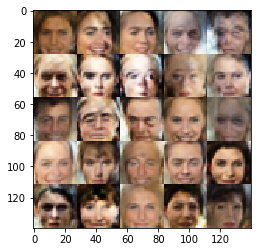

Epoch: 1, Batch: 3550, Disc. Loss: 1.177580, Gen. Loss: 0.823324
Epoch: 1, Batch: 3600, Disc. Loss: 1.150082, Gen. Loss: 0.739798
Epoch: 1, Batch: 3650, Disc. Loss: 1.115207, Gen. Loss: 0.898382
Epoch: 1, Batch: 3700, Disc. Loss: 1.237969, Gen. Loss: 0.865910
Epoch: 1, Batch: 3750, Disc. Loss: 1.232749, Gen. Loss: 0.738830
Epoch: 1, Batch: 3800, Disc. Loss: 1.176381, Gen. Loss: 0.767035
Epoch: 1, Batch: 3850, Disc. Loss: 1.225776, Gen. Loss: 0.658855
Epoch: 1, Batch: 3900, Disc. Loss: 1.338352, Gen. Loss: 0.574965
Epoch: 1, Batch: 3950, Disc. Loss: 1.264329, Gen. Loss: 1.061092
Epoch: 1, Batch: 4000, Disc. Loss: 1.228010, Gen. Loss: 0.651440


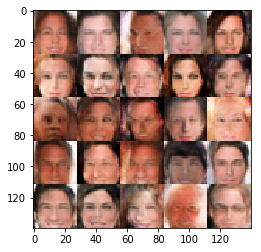

Epoch: 1, Batch: 4050, Disc. Loss: 1.230168, Gen. Loss: 0.705686
Epoch: 1, Batch: 4100, Disc. Loss: 1.257371, Gen. Loss: 0.779521
Epoch: 1, Batch: 4150, Disc. Loss: 1.228315, Gen. Loss: 0.906256
Epoch: 1, Batch: 4200, Disc. Loss: 1.174693, Gen. Loss: 0.755661
Epoch: 1, Batch: 4250, Disc. Loss: 1.118460, Gen. Loss: 0.770475
Epoch: 1, Batch: 4300, Disc. Loss: 1.249084, Gen. Loss: 0.701767
Epoch: 1, Batch: 4350, Disc. Loss: 1.172109, Gen. Loss: 0.720182
Epoch: 1, Batch: 4400, Disc. Loss: 1.131731, Gen. Loss: 0.861292
Epoch: 1, Batch: 4450, Disc. Loss: 1.317821, Gen. Loss: 0.691956
Epoch: 1, Batch: 4500, Disc. Loss: 1.304041, Gen. Loss: 0.831780


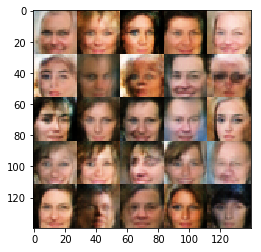

Epoch: 1, Batch: 4550, Disc. Loss: 1.302550, Gen. Loss: 0.565406
Epoch: 1, Batch: 4600, Disc. Loss: 1.196533, Gen. Loss: 0.814020
Epoch: 1, Batch: 4650, Disc. Loss: 1.014303, Gen. Loss: 0.946346
Epoch: 1, Batch: 4700, Disc. Loss: 1.039246, Gen. Loss: 0.776031
Epoch: 1, Batch: 4750, Disc. Loss: 1.238316, Gen. Loss: 0.789818
Epoch: 1, Batch: 4800, Disc. Loss: 1.205642, Gen. Loss: 0.763263
Epoch: 1, Batch: 4850, Disc. Loss: 1.209152, Gen. Loss: 0.778480
Epoch: 1, Batch: 4900, Disc. Loss: 1.228043, Gen. Loss: 1.072212
Epoch: 1, Batch: 4950, Disc. Loss: 1.247746, Gen. Loss: 0.699956
Epoch: 1, Batch: 5000, Disc. Loss: 1.182309, Gen. Loss: 0.785866


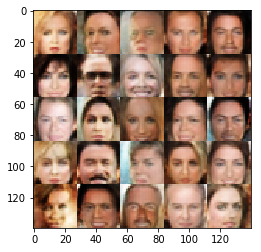

Epoch: 1, Batch: 5050, Disc. Loss: 1.225684, Gen. Loss: 0.686504
Epoch: 1, Batch: 5100, Disc. Loss: 1.310466, Gen. Loss: 0.620428
Epoch: 1, Batch: 5150, Disc. Loss: 1.373617, Gen. Loss: 0.708537
Epoch: 1, Batch: 5200, Disc. Loss: 1.117148, Gen. Loss: 0.750205
Epoch: 1, Batch: 5250, Disc. Loss: 1.152016, Gen. Loss: 0.722681
Epoch: 1, Batch: 5300, Disc. Loss: 1.214200, Gen. Loss: 0.786934
Epoch: 1, Batch: 5350, Disc. Loss: 1.226079, Gen. Loss: 0.835289
Epoch: 1, Batch: 5400, Disc. Loss: 1.215898, Gen. Loss: 1.277786
Epoch: 1, Batch: 5450, Disc. Loss: 1.390598, Gen. Loss: 0.701646
Epoch: 1, Batch: 5500, Disc. Loss: 1.221166, Gen. Loss: 0.778061


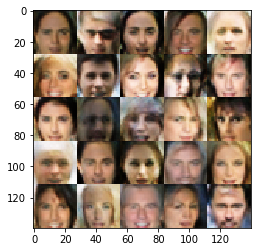

Epoch: 1, Batch: 5550, Disc. Loss: 1.207886, Gen. Loss: 0.962245
Epoch: 1, Batch: 5600, Disc. Loss: 1.112345, Gen. Loss: 0.927737
Epoch: 1, Batch: 5650, Disc. Loss: 1.199134, Gen. Loss: 0.739901
Epoch: 1, Batch: 5700, Disc. Loss: 1.054259, Gen. Loss: 0.725503
Epoch: 1, Batch: 5750, Disc. Loss: 1.092512, Gen. Loss: 1.059384
Epoch: 1, Batch: 5800, Disc. Loss: 1.149220, Gen. Loss: 0.791796
Epoch: 1, Batch: 5850, Disc. Loss: 1.054469, Gen. Loss: 0.891148
Epoch: 1, Batch: 5900, Disc. Loss: 1.009845, Gen. Loss: 0.866101
Epoch: 1, Batch: 5950, Disc. Loss: 1.127421, Gen. Loss: 0.818926
Epoch: 1, Batch: 6000, Disc. Loss: 1.066300, Gen. Loss: 0.829196


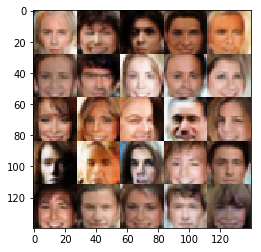

Epoch: 1, Batch: 6050, Disc. Loss: 1.086308, Gen. Loss: 0.706366
Epoch: 1, Batch: 6100, Disc. Loss: 1.176765, Gen. Loss: 1.484977
Epoch: 1, Batch: 6150, Disc. Loss: 1.182929, Gen. Loss: 0.639287
Epoch: 1, Batch: 6200, Disc. Loss: 1.227508, Gen. Loss: 1.041295
Epoch: 1, Batch: 6250, Disc. Loss: 0.996830, Gen. Loss: 1.084476
Epoch: 1, Batch: 6300, Disc. Loss: 1.141478, Gen. Loss: 1.236763


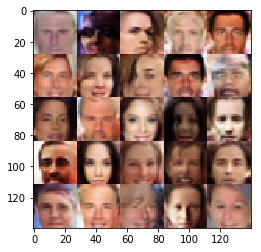

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    celeb_sess = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches, celeba_dataset.shape, 
                       celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.